In [ ]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras.metrics import AUC
from keras import callbacks
from sklearn.utils import class_weight

np.random.seed(0)

# LOADING DATA

In [ ]:
data = pd.read_csv("/content/weatherAUS.csv")
data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No



### **About the data:**

The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations.

In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108158 entries, 0 to 108157
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           108158 non-null  object 
 1   Location       108158 non-null  object 
 2   MinTemp        106935 non-null  float64
 3   MaxTemp        107116 non-null  float64
 4   Rainfall       105566 non-null  float64
 5   Evaporation    62579 non-null   float64
 6   Sunshine       54985 non-null   float64
 7   WindGustDir    101542 non-null  object 
 8   WindGustSpeed  101567 non-null  float64
 9   WindDir9am     99606 non-null   object 
 10  WindDir3pm     105062 non-null  object 
 11  WindSpeed9am   106628 non-null  float64
 12  WindSpeed3pm   106010 non-null  float64
 13  Humidity9am    106036 non-null  float64
 14  Humidity3pm    105602 non-null  float64
 15  Pressure9am    97472 non-null   float64
 16  Pressure3pm    97513 non-null   float64
 17  Cloud9am       67488 non-null


# DATA VISUALIZATION AND CLEANING

<ipython-input-4-226b9283729a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= data["RainTomorrow"], palette= cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

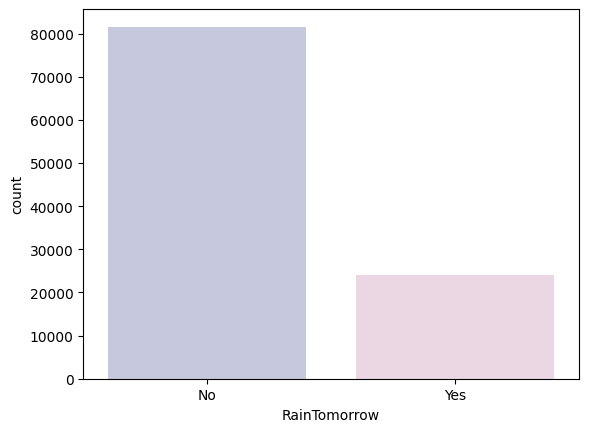

In [ ]:
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

### **Now I will parse Dates into datetime.**

My goal is to build an artificial neural network(ANN). I will encode dates appropriately, i.e. I prefer the months and days in a cyclic continuous feature. As, date and time are inherently cyclical. To let the ANN model know that a feature is cyclical I split it into periodic subsections. Namely, years, months and days. Now for each subsection, I create two new features, deriving a sine transform and cosine transform of the subsection feature

In [ ]:
lengths = data["Date"].str.len()
lengths.value_counts()

,count
Date,
10,108158


In [ ]:
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

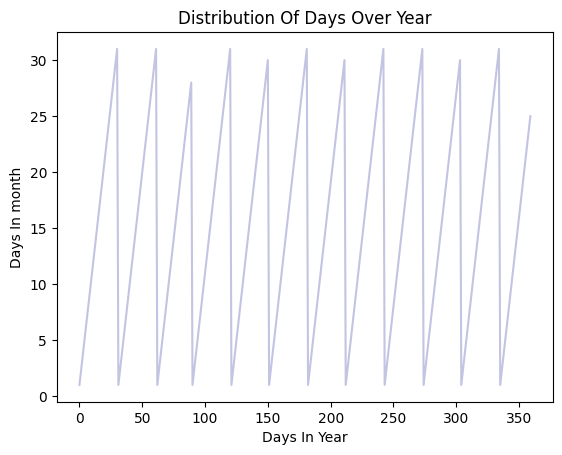

In [ ]:
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

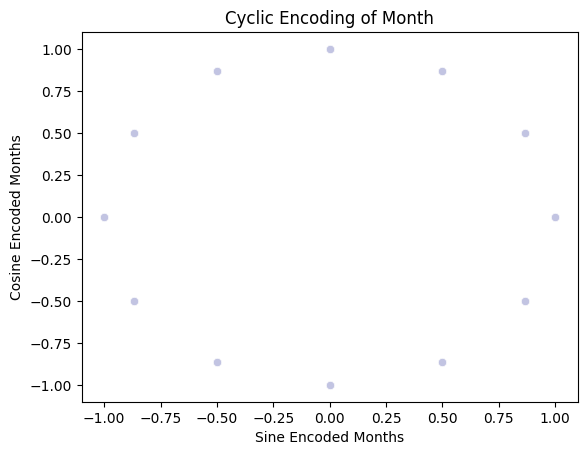

In [ ]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

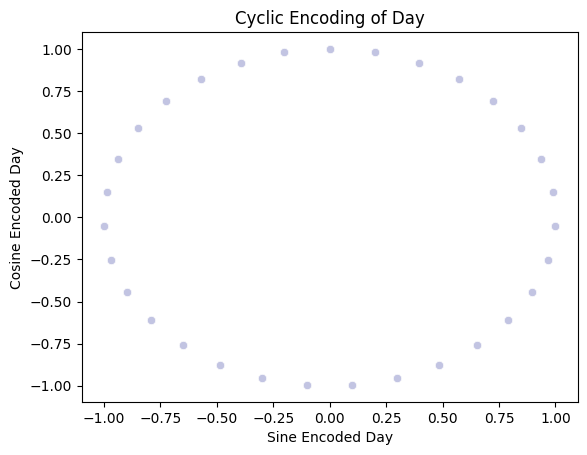

In [ ]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [ ]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 6616
WindDir9am 8552
WindDir3pm 3096
RainToday 2593
RainTomorrow 2594


In [ ]:
for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

<ipython-input-13-5707dd002bcd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


In [ ]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1223
MaxTemp 1042
Rainfall 2592
Evaporation 45579
Sunshine 53173
WindGustSpeed 6591
WindSpeed9am 1530
WindSpeed3pm 2148
Humidity9am 2122
Humidity3pm 2556
Pressure9am 10686
Pressure3pm 10645
Cloud9am 40670
Cloud3pm 42530
Temp9am 1579
Temp3pm 2062
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [ ]:
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108158 entries, 0 to 108157
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           108158 non-null  datetime64[ns]
 1   Location       108158 non-null  object        
 2   MinTemp        108158 non-null  float64       
 3   MaxTemp        108158 non-null  float64       
 4   Rainfall       108158 non-null  float64       
 5   Evaporation    108158 non-null  float64       
 6   Sunshine       108158 non-null  float64       
 7   WindGustDir    108158 non-null  object        
 8   WindGustSpeed  108158 non-null  float64       
 9   WindDir9am     108158 non-null  object        
 10  WindDir3pm     108158 non-null  object        
 11  WindSpeed9am   108158 non-null  float64       
 12  WindSpeed3pm   108158 non-null  float64       
 13  Humidity9am    108158 non-null  float64       
 14  Humidity3pm    108158 non-null  float64       
 15  

<ipython-input-17-a2df8648e601>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].median(), inplace=True)


Text(0.5, 0, 'Years')

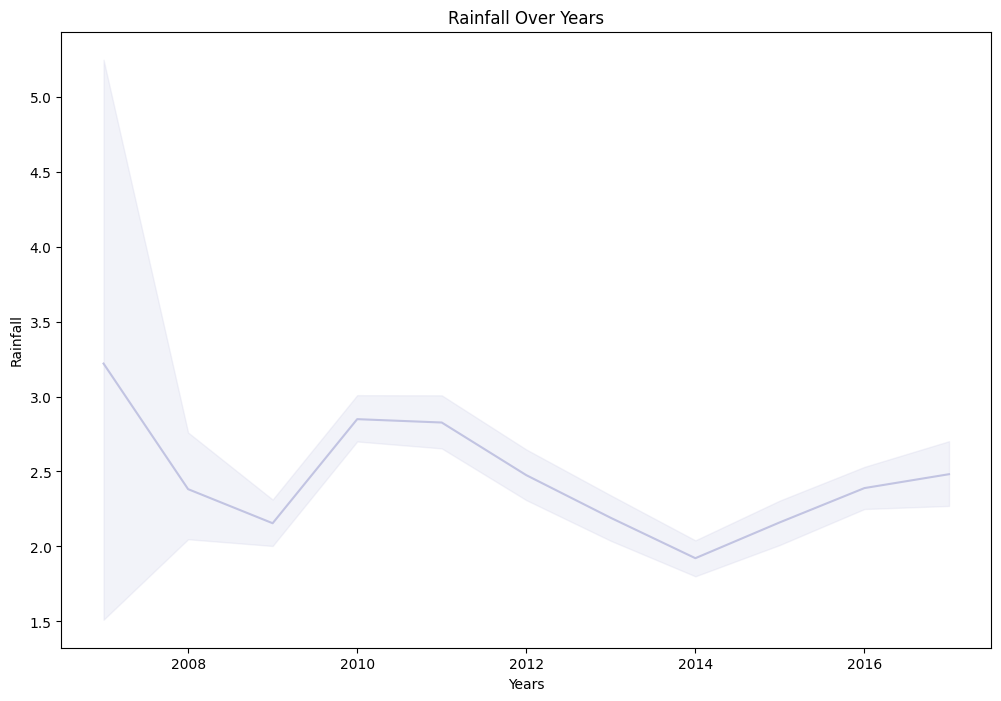

In [ ]:
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data,color="#C2C4E2")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

<ipython-input-19-574ace62e91a>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-19-574ace62e91a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
<ipython-input-19-574ace62e91a>:3: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)


Text(0.5, 0, 'Year')

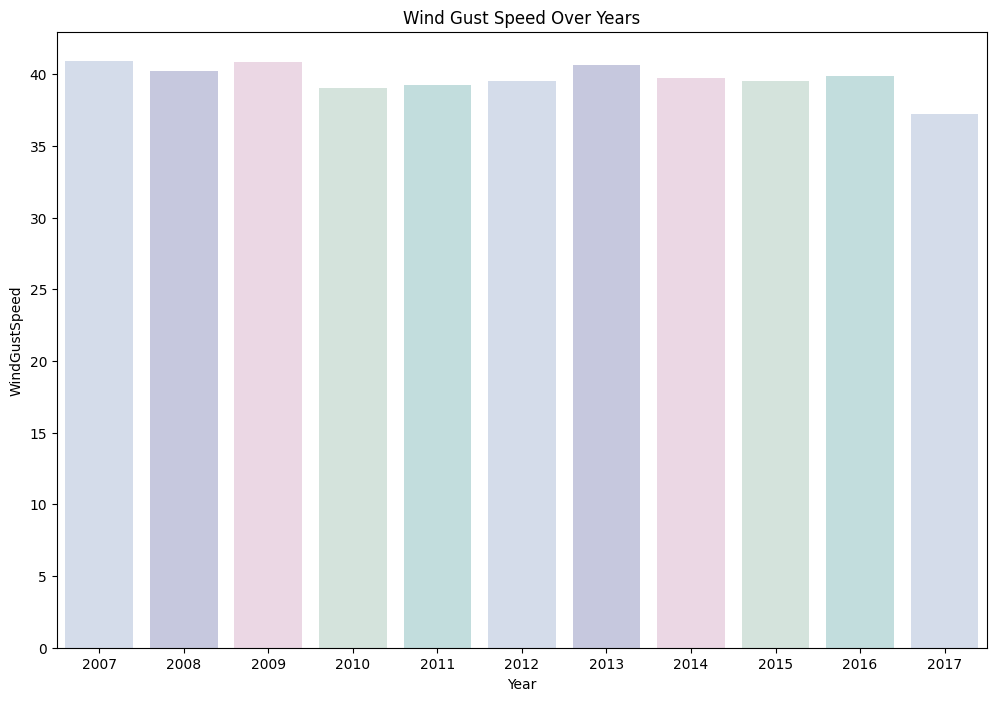

In [ ]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

# **DATA PREPROCESSING**
### **Steps involved in Data Preprocessing:**

Label encoding columns with categorical data

Perform the scaling of the features
Detecting outliers

Dropping the outliers based on data analysis
### **Label encoding the catagorical varable**

In [ ]:
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108158 entries, 0 to 108157
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           108158 non-null  datetime64[ns]
 1   Location       108158 non-null  int64         
 2   MinTemp        108158 non-null  float64       
 3   MaxTemp        108158 non-null  float64       
 4   Rainfall       108158 non-null  float64       
 5   Evaporation    108158 non-null  float64       
 6   Sunshine       108158 non-null  float64       
 7   WindGustDir    108158 non-null  int64         
 8   WindGustSpeed  108158 non-null  float64       
 9   WindDir9am     108158 non-null  int64         
 10  WindDir3pm     108158 non-null  int64         
 11  WindSpeed9am   108158 non-null  float64       
 12  WindSpeed3pm   108158 non-null  float64       
 13  Humidity9am    108158 non-null  float64       
 14  Humidity3pm    108158 non-null  float64       
 15  

In [ ]:
features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,108158.0,8.408945e-18,1.000005,-1.661826,-0.894923,-0.032158,0.926469,1.693372
MinTemp,108158.0,-4.288562e-16,1.000005,-3.231953,-0.722051,-0.011702,0.761790,3.461119
MaxTemp,108158.0,2.732907e-16,1.000005,-3.980348,-0.729561,-0.036059,0.686338,3.662614
Rainfall,108158.0,4.730032e-17,1.000005,-0.272185,-0.272185,-0.272185,-0.203322,42.308143
Evaporation,108158.0,5.129457e-16,1.000005,-1.527295,-0.312343,-0.130101,0.052142,42.514708
Sunshine,108158.0,-1.461054e-16,1.000005,-2.817522,0.115230,0.151436,0.187643,2.432466
WindGustDir,108158.0,9.998761e-17,1.000005,-1.747152,-0.891044,0.179091,1.035199,1.463253
WindGustSpeed,108158.0,1.849968e-16,1.000005,-2.421008,-0.642435,-0.197792,0.469173,7.064714
WindDir9am,108158.0,2.102236e-18,1.000005,-1.634065,-0.967731,-0.079285,0.809161,1.697607
WindDir3pm,108158.0,-8.408945e-18,1.000005,-1.689221,-0.809616,0.069989,0.949594,1.609298


<ipython-input-22-1ae9fffce728>:3: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


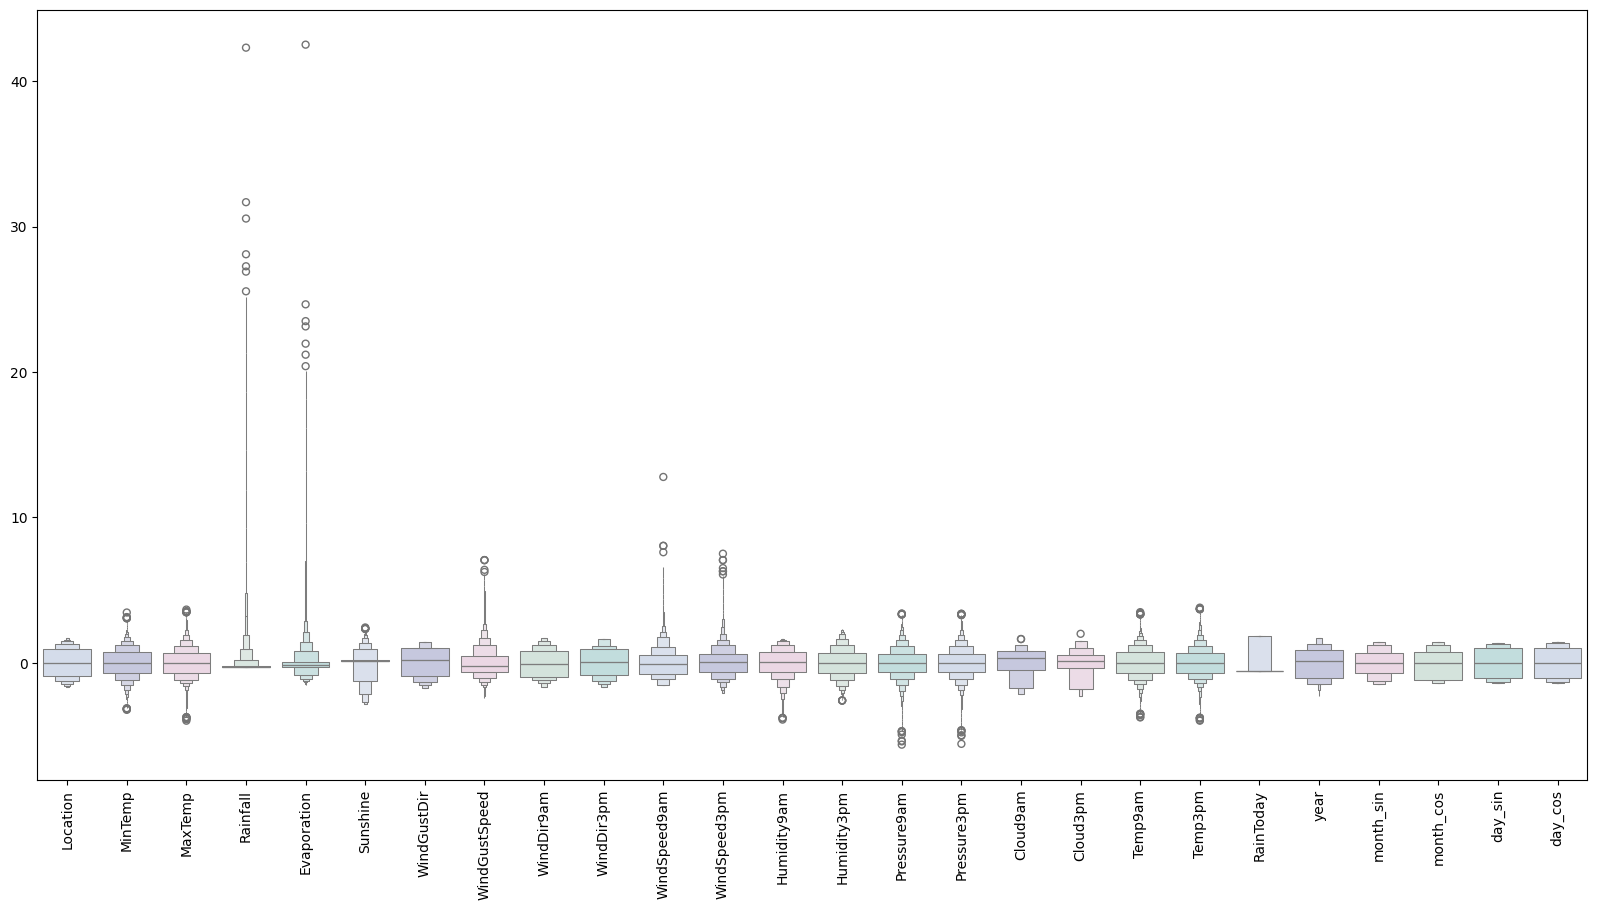

In [ ]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
features["RainTomorrow"] = target


features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(94504, 27)

<ipython-input-24-d3a7b3e4bca7>:2: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


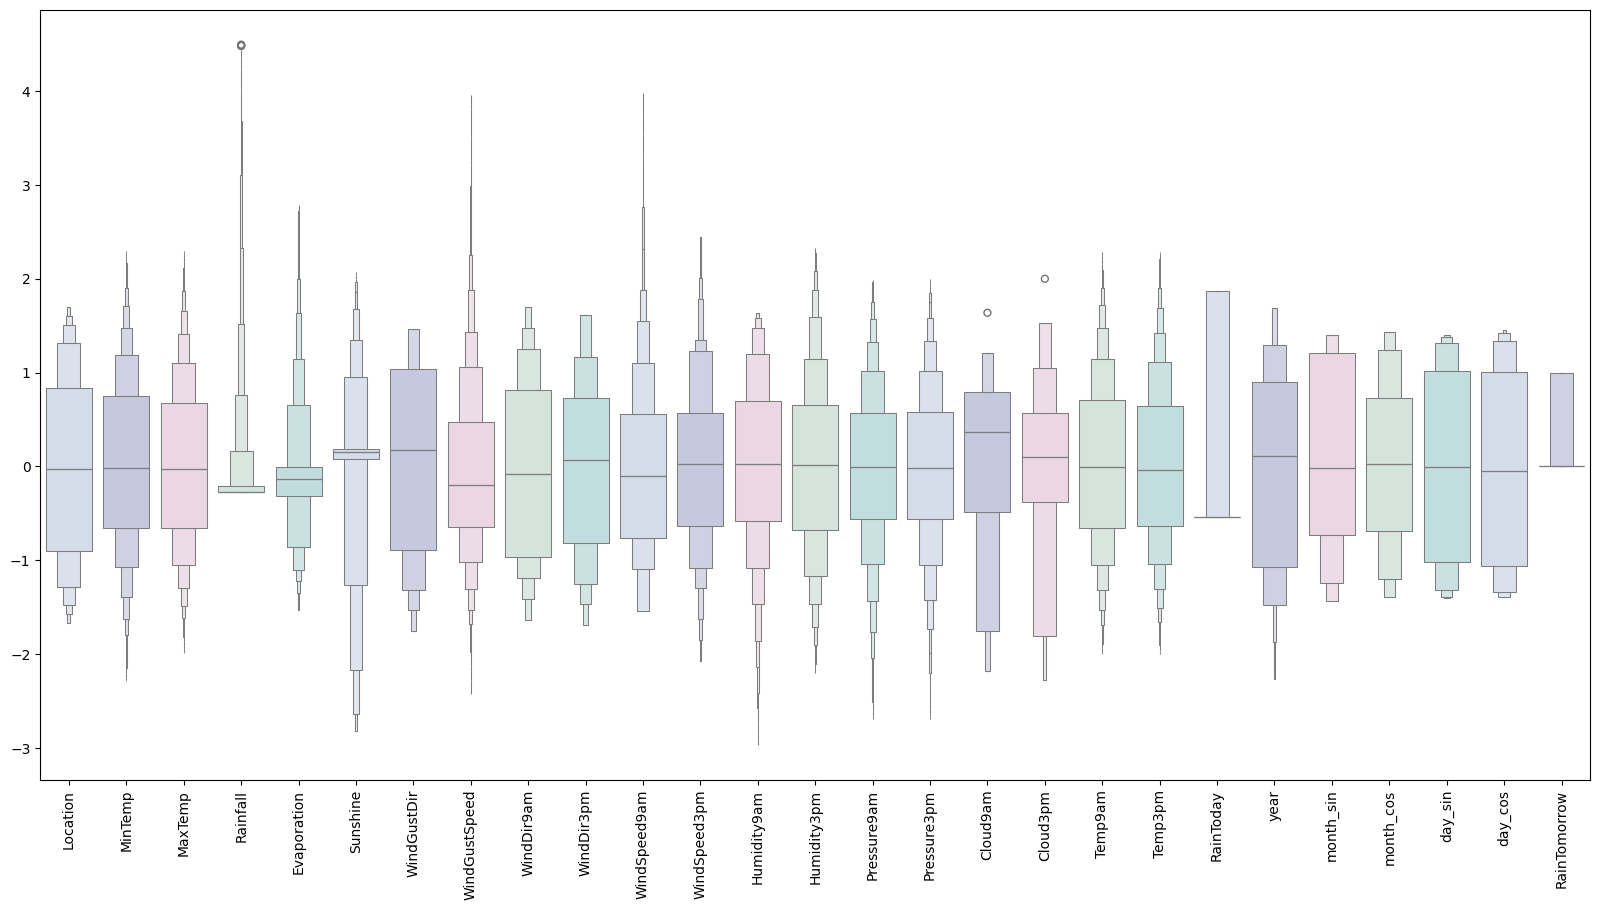

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

# **MODEL BUILDING**
### **In this project, we build an artificial neural network.**

### **Following steps are involved in the model building**

Assining X and y the status of attributes and tags

Splitting test and training sets
Initialising the neural network
Defining by adding layers

Compiling the neural network
Train the neural network

In [ ]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(94504, 26)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

model = Sequential()

model.add(Dense(units = 32, kernel_initializer = 'he_normal',kernel_regularizer=regularizers.l2(0.001), activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'he_normal',kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'he_normal',kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 8, kernel_initializer = 'he_normal',kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 1, kernel_initializer = 'he_normal',kernel_regularizer=regularizers.l2(0.001), activation = 'sigmoid'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy',AUC()])

history = model.fit(X_train, y_train, batch_size = 64, epochs = 150, callbacks=[early_stopping], validation_split=0.2,class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5660 - auc: 0.6195 - loss: 0.8601 - val_accuracy: 0.7420 - val_auc: 0.8418 - val_loss: 0.6623
Epoch 2/150
946/946 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7388 - auc: 0.8105 - loss: 0.6679 - val_accuracy: 0.7759 - val_auc: 0.8562 - val_loss: 0.5765
Epoch 3/150
946/946 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7615 - auc: 0.8321 - loss: 0.6142 - val_accuracy: 0.7887 - val_auc: 0.8601 - val_loss: 0.5424
Epoch 4/150
946/946 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7674 - auc: 0.8432 - loss: 0.5766 - val_accuracy: 0.7861 - val_auc: 0.8625 - val_loss: 0.5314
Epoch 5/150
946/946 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7643 - auc: 0.8457 - loss: 0.5564 - val_accuracy: 0.7800 - val_auc: 0.8654 - val_loss: 0.5207
Epoch 6/150
946/946 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7706 - auc: 0.8541 - loss: 0.5345 - val_accuracy: 0.7901 - val_auc: 0.8673 - val_loss: 0.4994
Epoch 7/150
946/946 ━━━━━━━━━━━━━━

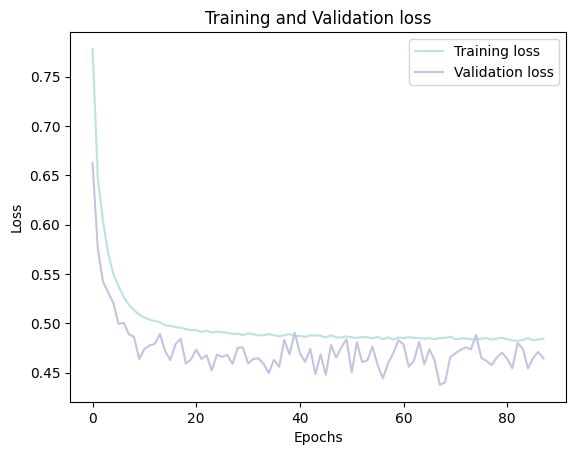

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

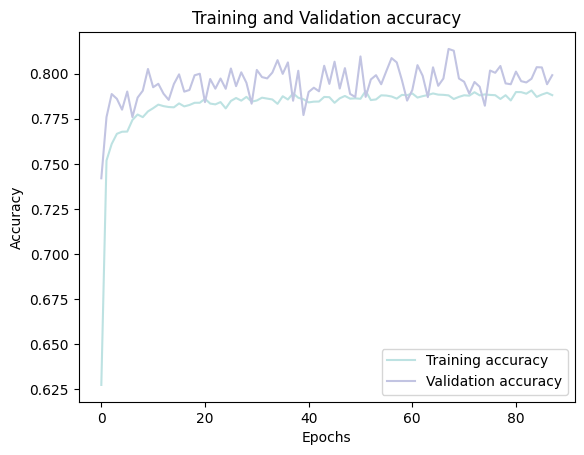

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **CONCLUSIONS**
### **Concluding the model with:**

Testing on the test set

Evaluating the confusion matrix

Evaluating the classification report

Explaining the model with SHAP

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)


591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Axes: >

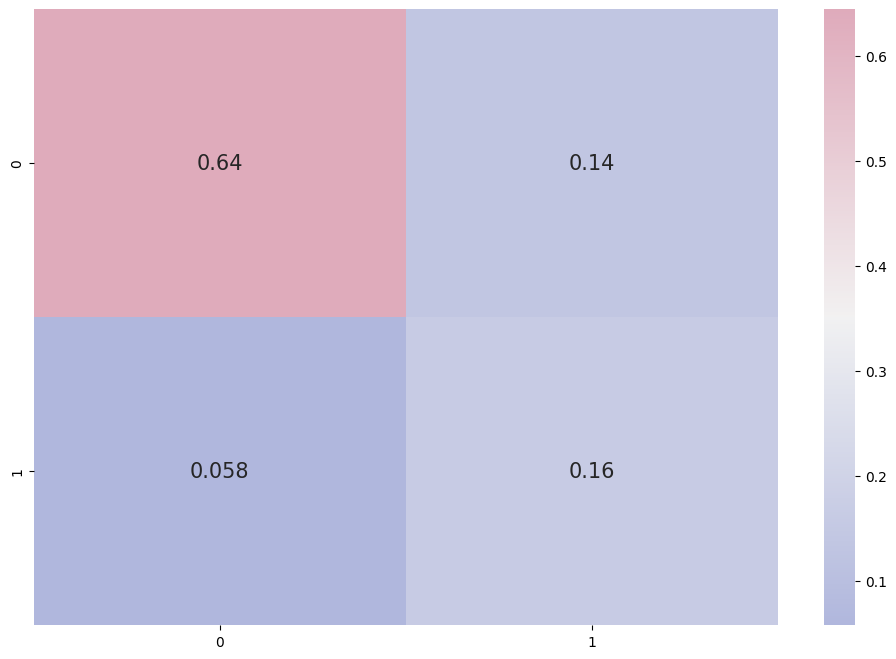

In [ ]:
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     14744
           1       0.54      0.74      0.63      4157

    accuracy                           0.81     18901
   macro avg       0.73      0.78      0.75     18901
weighted avg       0.84      0.81      0.82     18901

